<a href="https://colab.research.google.com/github/Ihalagedara/FYP2-IDS/blob/colab/anormal_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import kerastuner as kt

Using TensorFlow backend


<ipython-input-3-9d3291f76797>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [4]:
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [5]:
data = pd.read_csv('/content/drive/Shareddrives/FYP IDS SDN/FYP ML/InSDN_DatasetCSV/new_dataset.csv', sep=",")

In [6]:
#condition3 = data['Label'] != 'Probe'
condition4 = data['Label'] != 'Normal'
data = data.drop(data[condition4].index)

In [7]:
#data['Label'] = data['Label'].replace('Probe', 1)
data['Label'] = data['Label'].replace('Normal', 0)

In [8]:
data = data.drop(['Flow ID','Src IP','Src Port','Dst IP', 'Dst Port', 'Timestamp'], axis=1)


In [9]:
data, data_test = train_test_split(data, test_size=0.2)

In [10]:
y_data = data["Label"]
data = data.drop(["Label"],axis=1)
y_data_test = data_test["Label"]
data_test = data_test.drop(["Label"],axis=1)

In [11]:
selected_features = ['Protocol', 'Tot Fwd Pkts', 'Flow Pkts/s', 'Fwd Header Len', 'Bwd Header Len', 'Bwd Pkts/s', 'Pkt Len Max', 'Init Bwd Win Byts']
data = data.drop(columns=data.columns.difference(selected_features))
data_test = data_test.drop(columns=data_test.columns.difference(selected_features))

In [12]:
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)

normalized_data = (data - mean) / std_dev

In [13]:
msle = MeanSquaredLogarithmicError()

In [14]:
def build_model(hp):
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=1024, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=1024, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=1024, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=1024, step=32)
  hp_units5 = hp.Int('units5', min_value=32, max_value=1024, step=32)
  hp_units6 = hp.Int('units6', min_value=32, max_value=1024, step=32)
  hp_units7 = hp.Int('units7', min_value=32, max_value=1024, step=32)
  hp_units8 = hp.Int('units8', min_value=32, max_value=1024, step=32)
  hp_units9 = hp.Int('units9', min_value=32, max_value=1024, step=32)
  model.add(Dense(units=hp_units1, input_shape=(7,), activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units4, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units5, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units6, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units7, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units8, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units9, activation='relu'))
  model.add(tf.keras.layers.Dense(units=2, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units9, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units8, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units7, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units6, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units5, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units4, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units1, activation='relu'))
  model.add(Dense(7, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
      loss='mse',
      metrics=["accuracy"]
  )
  return model

In [15]:
tuner1 = kt.Hyperband(
    build_model,
    objective=['accuracy', 'val_loss'],
    max_epochs=20,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo'
)

In [16]:
tuner1.search(normalized_data, normalized_data, epochs=20,batch_size = 68 ,validation_split=0.2)

Trial 30 Complete [00h 02m 05s]
multi_objective: 0.7151806652545929

Best multi_objective So Far: -0.7136264741420746
Total elapsed time: 00h 30m 41s


In [17]:
for h_param in [f"units{i}" for i in range(1,10)] + ['learning_rate']:
  print(h_param, tuner1.get_best_hyperparameters()[0].get(h_param))

units1 320
units2 416
units3 320
units4 128
units5 704
units6 608
units7 224
units8 224
units9 576
learning_rate 0.0001


In [18]:
model = keras.Sequential([
    Dense(units=640, input_shape=(7,), activation='relu'),
    Dense(units=1024, activation='relu'),
    Dense(units=192, activation='relu'),
    Dense(units=608, activation='relu'),

    Dense(units=608, activation='relu'),
    Dense(units=352, activation='relu'),
    Dense(units=160, activation='relu'),

    Dense(units=1024, activation='relu'),
    Dense(units=544, activation='relu'),

    Dense(units=2, activation='relu'),

    Dense(units=544, activation='relu'),
    Dense(units=1024, activation='relu'),
    Dense(units=160, activation='relu'),
    Dense(units=352, activation='relu'),
    Dense(units=608, activation='relu'),

    Dense(units=608, activation='relu'),
    Dense(units=192, activation='relu'),

    Dense(units=1024, activation='relu'),
    Dense(units=640, activation='relu'),

    Dense(units=7, activation='linear')
])

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mse',metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 640)               5120      
                                                                 
 dense_21 (Dense)            (None, 1024)              656384    
                                                                 
 dense_22 (Dense)            (None, 192)               196800    
                                                                 
 dense_23 (Dense)            (None, 608)               117344    
                                                                 
 dense_24 (Dense)            (None, 608)               370272    
                                                                 
 dense_25 (Dense)            (None, 352)               214368    
                                                                 
 dense_26 (Dense)            (None, 160)              

In [21]:
dl = model.fit(data, data, epochs=50, batch_size=68,validation_split=0.2)

Epoch 1/50
644/644 [==============================] - 14s 9ms/step - loss: 261909296.0000 - accuracy: 0.6444 - val_loss: 1189789568.0000 - val_accuracy: 0.6181
Epoch 2/50
644/644 [==============================] - 6s 9ms/step - loss: 76461048.0000 - accuracy: 0.6331 - val_loss: 13040979.0000 - val_accuracy: 0.6141
Epoch 3/50
644/644 [==============================] - 6s 10ms/step - loss: 80745840.0000 - accuracy: 0.7450 - val_loss: 38076920.0000 - val_accuracy: 0.8949
Epoch 4/50
644/644 [==============================] - 5s 8ms/step - loss: 29725166.0000 - accuracy: 0.7844 - val_loss: 104621792.0000 - val_accuracy: 0.8490
Epoch 5/50
644/644 [==============================] - 6s 10ms/step - loss: 573345216.0000 - accuracy: 0.8372 - val_loss: 419746048.0000 - val_accuracy: 0.9160
Epoch 6/50
644/644 [==============================] - 5s 8ms/step - loss: 15860590.0000 - accuracy: 0.9083 - val_loss: 11758192.0000 - val_accuracy: 0.9340
Epoch 7/50
644/644 [==============================] - 6

In [22]:
print(f"max accuracy {max(dl.history['accuracy'])} : index {dl.history['accuracy'].index(max(dl.history['accuracy']))}")
print(f"max val accuracy {max(dl.history['val_accuracy'])} : index {dl.history['val_accuracy'].index(max(dl.history['val_accuracy']))}")
print(f"min loss {min(dl.history['loss'])} : index {dl.history['loss'].index(min(dl.history['loss']))}")
print(f"min val loss {min(dl.history['val_loss'])} : index {dl.history['val_loss'].index(min(dl.history['val_loss']))}")

max accuracy 0.9195953607559204 : index 49
max val accuracy 0.9339605569839478 : index 5
min loss 3031023.25 : index 44
min val loss 5284069.0 : index 48


In [23]:
from matplotlib import pyplot as plt


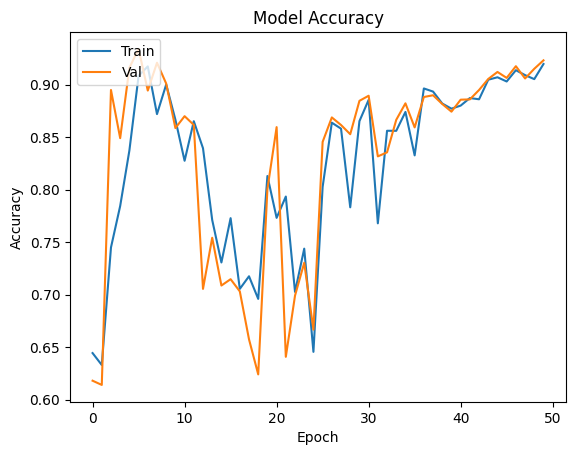

In [24]:
plt.plot(dl.history['accuracy'])
plt.plot(dl.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

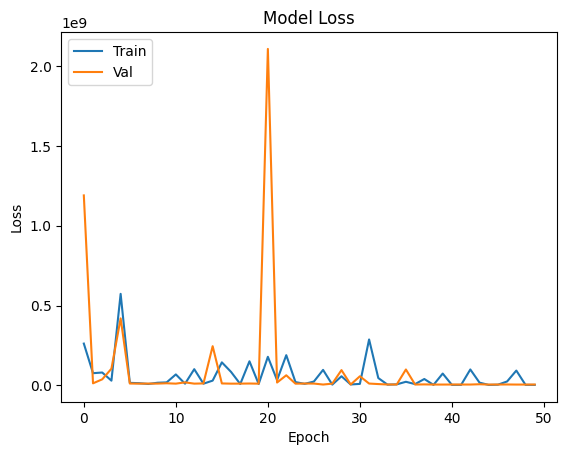

In [25]:
plt.plot(dl.history['loss'])
plt.plot(dl.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [139]:
data = pd.read_csv('/content/drive/Shareddrives/FYP IDS SDN/FYP ML/InSDN_DatasetCSV/new_dataset.csv', sep=",")

In [140]:
data = data.drop(['Flow ID','Src IP','Src Port','Dst IP', 'Dst Port', 'Timestamp'], axis=1)

In [141]:
selected_features = ['Protocol', 'Tot Fwd Pkts', 'Flow Pkts/s', 'Fwd Header Len', 'Bwd Header Len', 'Bwd Pkts/s', 'Pkt Len Max', 'Init Bwd Win Byts','Label']
data = data.drop(columns=data.columns.difference(selected_features))

In [142]:
data['Label'][data['Label'] != 'Normal'] = 1

<ipython-input-142-e55ce4b1c867>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'][data['Label'] != 'Normal'] = 1


In [143]:
data['Label'][data['Label']=='Normal'] = 0

<ipython-input-143-0d0b528d951f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'][data['Label']=='Normal'] = 0


In [144]:
y_data = data["Label"]
data = data.drop(["Label"],axis=1)

In [99]:
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)

norm_data = (data - mean) / std_dev

In [145]:
y_data.unique()

array([1, 0], dtype=object)

In [146]:
data = np.array(data)

In [147]:
data[0]

array([   6.      ,    2.      , 1730.53152 ,   64.      ,  176.      ,
       1236.093943, 1803.      ])

In [150]:
reconstructions = model.predict(data)

10747/10747 [==============================] - 26s 2ms/step


In [152]:
mse = np.mean(np.square(data - reconstructions*3), axis=1)

In [154]:
threshold = np.percentile(mse/1000, 95)

is_anomaly = mse > threshold

In [151]:
reconstructions

array([[7.6615076e+00, 5.5885391e+00, 9.0324806e+01, ..., 4.4003220e+02,
        4.7903778e+01, 1.1867208e+03],
       [3.7683620e+00, 7.8033641e-02, 7.1017163e+03, ..., 6.3180089e+00,
        3.5541479e+03, 3.7532933e+00],
       [3.3956623e+00, 6.7064667e+00, 4.7100571e+01, ..., 5.5256128e+02,
        2.7508438e+01, 1.4879493e+03],
       ...,
       [3.4616871e+00, 1.5682471e+00, 8.4813515e+01, ..., 2.0367378e+01,
        4.3241539e+01, 6.8425430e+01],
       [3.5701213e+00, 1.6689770e+00, 8.7678894e+01, ..., 2.2264189e+01,
        4.4610920e+01, 7.3527306e+01],
       [2.8446870e+00, 1.6362841e+00, 8.8037949e+01, ..., 1.4212748e+01,
        4.4697956e+01, 5.1002895e+01]], dtype=float32)

In [153]:
mse

array([1.16772799e+06, 3.63471895e+07, 1.91010937e+06, ...,
       2.06039829e+04, 1.66416155e+04, 1.98693040e+04])

In [161]:
is_anomaly[is_anomaly != 'False'] = 0

<ipython-input-161-2f45274dd573>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  is_anomaly[is_anomaly != 'False'] = 0


In [162]:
is_anomaly[is_anomaly == 'False'] = 1

<ipython-input-162-41ce8964219f>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  is_anomaly[is_anomaly == 'False'] = 1


In [183]:
an = []
for i in range(len(is_anomaly)):
  if is_anomaly[i]:
    an.append(0)
  else:
    an.append(1)

In [184]:
an =np.array(an)

In [185]:
y_data = np.array(y_data)

In [201]:
an

array([1, 1, 1, ..., 1, 1, 1])

In [202]:
y_data

array([1, 1, 1, ..., 1, 1, 1], dtype=object)

In [192]:
mse1 = np.mean(np.square(y_data - an))

In [194]:
mse1

0.19897117965389996

In [199]:
count =0
for i in range(len(an)):
  if an[i] == y_data[i]:
    count = count +1

count/len(an)

0.8010288203461

In [188]:
accuracy_score(y_data, an)

ValueError: ignored

In [200]:
print(classification_report(y_data, an))

ValueError: ignored

In [ ]:
plt.plot(is_anomaly)

ValueError: ignored

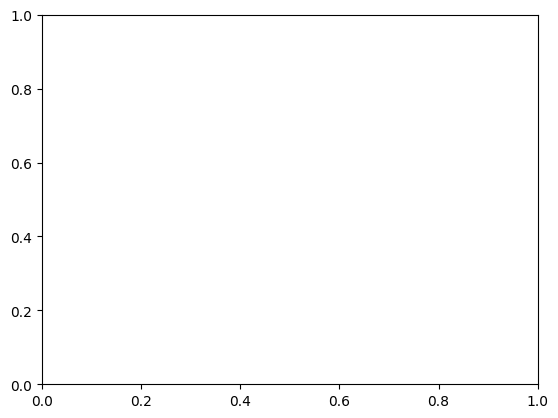

In [40]:
plt.scatter(data[:54739],data[:54739],c=is_anomaly, cmap='viridis')
plt.title("Autoencoder-Based Anomaly Detection")
plt.show()